<a href="https://colab.research.google.com/github/Oshada-Kasun/skin-cancer-detection/blob/main/notebooks/EB3_EB4_Partial_Dataset_Skin_Cancer_TFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, math, pathlib, re, gc, time, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import time

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

!pip install pip install tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
print("\nTensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 


Tensorflow version 2.7.0


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.12.210.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.210.66:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.12.210.66:8470
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [ ]:
N_CHANNELS = 3
N_CLASSES = 1 # use 1 for binary 

REPLICAS = strategy.num_replicas_in_sync
IMAGES_PER_REPLICA = 20 
BATCH_SIZE = IMAGES_PER_REPLICA * REPLICAS

EPOCHS = 16
buffer_size = 10000 #(used for data shuffling OOM if too large)

In [ ]:
print("Batch size: ",BATCH_SIZE)
print("Number of replicas: ",REPLICAS)

Batch size:  160
Number of replicas:  8


In [ ]:
GCS_PATH_2020 = "gs://kds-a5dd9f0eb26778fddaa4f0759d9471b1eadbf1ee1057043427ad04dd"
TRAIN_2020 = tf.io.gfile.glob(GCS_PATH_2020 + '/train*.tfrec')

In [ ]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    return example['image'], example['image_name'], example['target'] 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    return example['image'], example['image_name']

def load_dataset(filenames, labeled = True, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else 
                          read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [ ]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
cd /content/drive/MyDrive/FourthBrain/Capstone\ Project/Notebooks

/content/drive/MyDrive/FourthBrain/Capstone Project/Notebooks


In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [ ]:
from helper_functions.utils import *

In [ ]:
def countRecords(ds:tf.data.Dataset):
  count = 0

  if tf.executing_eagerly():
    # TF v2 or v1 in eager mode
    for r in ds:
      count = count+1
  else:  
    # TF v1 in non-eager mode
    iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
    next_batch = iterator.get_next()
    with tf.compat.v1.Session() as sess:
      try:
        while True:
          sess.run(next_batch)
          count = count+1    
      except tf.errors.OutOfRangeError:
        pass
  
  return count

In [ ]:
def load_dataset_new(filenames, labeled = True, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = ordered 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else 
                          read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [ ]:
def getTrainingElements(image, target):
  return image, target

In [ ]:
def get_built_train_dataset(built_train_dataset,buf_size):
  built_train_dataset = built_train_dataset.map(lambda image, image_name, target:
                                          getTrainingElements(image, target), 
                                          num_parallel_calls=AUTO)
  built_train_dataset = built_train_dataset.repeat() 
  built_train_dataset = built_train_dataset.shuffle(buffer_size = buf_size)
  built_train_dataset = built_train_dataset.batch(BATCH_SIZE)
  built_train_dataset = built_train_dataset.prefetch(AUTO)

  return built_train_dataset 


In [ ]:
def get_built_valid_dataset(built_valid_dataset):
  built_valid_dataset = built_valid_dataset.map(lambda image, image_name, target:
                                          getTrainingElements(image, target), 
                                          num_parallel_calls=AUTO)
  built_valid_dataset = built_valid_dataset.batch(BATCH_SIZE)
  built_valid_dataset = built_valid_dataset.cache() 
  built_valid_dataset = built_valid_dataset.prefetch(AUTO)

  return built_valid_dataset

In [ ]:
def get_built_test_dataset(built_test_dataset):
  #built_test_dataset = built_test_dataset.batch(1000)
  # built_test_dataset = built_test_dataset.map(lambda image, image_name, target:image_name, 
  #                                         num_parallel_calls=AUTO)
  built_test_dataset = built_test_dataset.cache() 
  built_test_dataset = built_test_dataset.prefetch(AUTO)
  
  return built_test_dataset

In [ ]:
def is_test(x, y):
  return x % 10 == 7

def is_train(x, y):
  return x % 10 <7

def is_valid(x, y):
  return x % 10 >7

def splitDataset(dataset,shuffle=False):
  countRecs = countRecords(dataset)
  recover = lambda x,y: y
  if shuffle:
    dataset = dataset.shuffle(countRecs, reshuffle_each_iteration=False)

  test_dataset = dataset.enumerate().filter(is_test).map(lambda x,y: y) 
  val_dataset = dataset.enumerate().filter(is_valid).map(lambda x,y: y) 
  train_dataset = dataset.enumerate().filter(is_train).map(lambda x,y: y)

  return train_dataset, val_dataset, test_dataset



In [ ]:
def decode_image_new(image_data, image_name, label, resize, target_size):
    # Used for the validation set (for now)
    image = tf.image.decode_jpeg(image_data, channels=N_CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    if resize:
        image = tf.image.resize(image, target_size)
    image = tf.reshape(image, [*target_size, N_CHANNELS]) # explicit size NEEDED for TPU
    return image, image_name, label

In [ ]:
def data_augment_new(image, image_name, label_or_id, DIM, target_size, augm_method): 
    # image = tf.image.decode_jpeg(image, channels=N_CHANNELS)
    # image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    # image = tf.image.resize(image, target_size)

    # during TTA, label_or_id will be image_name for test set.
    if augm_method == 1:
    #if tf.keras.backend.random_bernoulli((1,), p=0.4) > 0:
        image = rotate_img(image, DIM = DIM)
    elif augm_method == 2:
    #elif tf.keras.backend.random_bernoulli((1,), p=0.2) > 0:
        image = shear_img(image, DIM = DIM)
    elif augm_method == 3:
      image = tf.image.random_flip_left_right(image)
    elif augm_method == 4:
      image = tf.image.random_flip_up_down(image)
    elif augm_method == 5:
      image = tf.image.random_hue(image, 0.025)
    elif augm_method == 6:
      image = tf.image.random_saturation(image, 0.7, 1.4)
    elif augm_method == 7:
      image = tf.image.random_contrast(image, 0.7, 1.4)
    elif augm_method == 8:
      image = tf.image.random_brightness(image, 0.2)

    #image = tf.reshape(image, [*target_size, N_CHANNELS]) # explicit size NEEDED for TPU
    return image, image_name, label_or_id

In [ ]:
def augmentImages(dataset_test_true,dim):

  dataset_test_true_aug = dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],1), 
                            num_parallel_calls=AUTO)
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],2), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],3), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],4), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],5), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],6), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],7), 
                            num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
                            data_augment_new(image, image_name, target, dim, [dim, dim],8), 
                            num_parallel_calls=AUTO))

  # dataset_test_true_aug = dataset_test_true_aug.concatenate(dataset_test_true.map(lambda image, image_name, target: 
  #                           data_augment_new(image, image_name, target, dim, [dim, dim],0), 
  #                           num_parallel_calls=AUTO))
  dataset_test_true_aug = dataset_test_true_aug.cache()
  dataset_test_true_aug = dataset_test_true_aug.prefetch(AUTO)

  return dataset_test_true_aug

In [ ]:
def build_datasets_new(model_dict):
    DIM = model_dict['DIM']

    all_train_dataset_2020  = load_dataset_new([TRAIN_2020],ordered =False)

    all_train_dataset_true  = all_train_dataset_2020.filter(lambda image, image_name, target: tf.reduce_all(tf.not_equal(target, [0])))
    all_train_dataset_true = all_train_dataset_true.map(lambda image, image_name, target: 
                          decode_image_new(image, image_name, target, True, [DIM,DIM]),
                          num_parallel_calls=AUTO)
    all_train_dataset_true = all_train_dataset_true.cache() 
    all_train_dataset_true  = all_train_dataset_true.prefetch(AUTO)

    train_dataset_true, val_dataset_true, test_dataset_true = splitDataset(all_train_dataset_true,shuffle=True)
    count_train_true = countRecords(train_dataset_true)
    count_valid_true = countRecords(val_dataset_true)
    count_test_true  = countRecords(test_dataset_true)
    print("============= Initial Malignant Data Counts ==============")
    print(" Training : ",count_train_true)
    print(" Validation: ",count_valid_true)
    print(" Test : ",count_test_true)
    print("==========================================================")
    train_dataset_true_aug = augmentImages(train_dataset_true,DIM)
    count_train_true_aug = countRecords(train_dataset_true_aug)
    print(" Augmented Malignant Training Count : ",count_train_true_aug)
    build_train_dataset_true = train_dataset_true_aug.concatenate(train_dataset_true)
    count_build_train_true = countRecords(build_train_dataset_true)
    print(" All Malignant Training Count : ",count_build_train_true)

    all_train_dataset_false = all_train_dataset_2020.filter(lambda image, image_name, target: tf.reduce_all(tf.not_equal(target, [1])))
    all_train_dataset_false = all_train_dataset_false.map(lambda image, image_name, target: 
                          decode_image_new(image, image_name, target, True, [DIM,DIM]),
                          num_parallel_calls=AUTO)
    all_train_dataset_false = all_train_dataset_false.cache() 
    all_train_dataset_false  = all_train_dataset_false.prefetch(AUTO)

    train_dataset_false, val_dataset_false, test_dataset_false = splitDataset(all_train_dataset_false,shuffle=True)
    count_train_false = countRecords(train_dataset_false)
    count_val_false   = countRecords(val_dataset_false) 
    count_test_false  = countRecords(test_dataset_false)
    print("============= Initial Bening Data Counts ==============")
    print(" Training : ",count_train_false)
    print(" Validation: ",count_val_false)
    print(" Test : ",count_test_false)
    print("==========================================================")
    train_dataset_false = train_dataset_false.take(count_build_train_true)
    val_dataset_false = val_dataset_false.take(count_valid_true*2)
    test_dataset_false = val_dataset_false.take(count_test_true*2)
    count_built_train_false = countRecords(train_dataset_false)
    count_built_val_false   = countRecords(val_dataset_false) 
    count_built_test_false  = countRecords(test_dataset_false)
    print("============= Selected Bening Data Counts ==============")
    print(" Training : ",count_built_train_false)
    print(" Validation: ",count_built_val_false)
    print(" Test : ",count_built_test_false)
    print("==========================================================")

    built_train_dataset = train_dataset_false.concatenate(build_train_dataset_true)
    built_valid_dataset = val_dataset_false.concatenate(val_dataset_true)
    built_test_dataset  = test_dataset_false.concatenate(test_dataset_true)
    
    NUM_TRAINING_IMAGES = countRecords(built_train_dataset)
    NUM_VALIDATION_IMAGES = countRecords(built_valid_dataset)
    NUM_TEST_IMAGES = countRecords(built_test_dataset)
    STEPS_PER_EPOCH = np.ceil(NUM_TRAINING_IMAGES/BATCH_SIZE).astype(int) 

    built_train_dataset = get_built_train_dataset(built_train_dataset,NUM_TRAINING_IMAGES)

    built_valid_dataset = get_built_valid_dataset(built_valid_dataset)

    built_test_dataset = get_built_test_dataset(built_test_dataset)
    #LIST_BULD_TESTDATASET.append({model_dict["name"]:built_test_dataset})

    print("============= Final Built Data Counts ==============")
    print(" Training : ",NUM_TRAINING_IMAGES)
    print(" Validation: ",NUM_VALIDATION_IMAGES)
    print(" Test : ",NUM_TEST_IMAGES)
    print("==========================================================")

    print('\n')
    describe_ds(built_train_dataset)
    describe_ds(built_valid_dataset)
    describe_ds(built_test_dataset)
    return built_train_dataset, built_valid_dataset, built_test_dataset, STEPS_PER_EPOCH, [NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES]

In [ ]:
def showAugmentedImages(dataset_orig, dataset_aug, idx=0):
  countAug = countRecords(dataset_aug)
  countOrg = countRecords(dataset_orig)
  list_imgs = []

  image, image_name, label = next(iter(dataset_aug.skip(idx)))
  if label ==1:
    img_label = "MALIGNANT"
  elif label ==0:
    img_label = "BENIGN"
  plt.imshow(image)
  plt.title("Original Image (" + str(image_name.numpy())+" => "+ img_label+" )")
  plt.axis("off")

  for i in range(8):
    i += ((countOrg-1)*i)+idx
    print(" ==> ",i)
    image, image_name, label = next(iter(dataset_aug.skip(i)))
    imgAug = {
        "image":image,
        "image_name":image_name,
        "label":label
    }
    list_imgs.append(imgAug)
  plt.figure(figsize=(25, 25))
  for index,imgs in enumerate(list_imgs):
    ax = plt.subplot(5, 5, index + 1)
    plt.imshow(imgs.get("image"))
    if imgs.get("label") ==1:
      img_label = "MALIGNANT"
    elif imgs.get("label") ==0:
      img_label = "BENIGN"
    plt.title(str(imgs.get("image_name").numpy())+" => "+ img_label)
    plt.axis("off")


# **Data Visualization**

In [ ]:
gen_examples = True #@param {type:"boolean"}
num_batches = 5 #@param [2, 3, 5, 10] {type:'raw'}

if gen_examples:
    temp_filenames, _ = get_fold_file_lists(folds[4], data_2018=False)
    temp_dataset = get_training_dataset(temp_filenames, 224)
    raw_tuples = generate_examples(ds = temp_dataset, n_batches = num_batches)
    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


Label: Benign
Image size: (224, 224, 3)


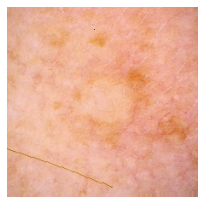

In [ ]:
idx = 0
if gen_examples:
    if idx >= len(raw_tuples): idx = -1
    example_tuple = raw_tuples[idx]
    plot_example(example_tuple, print_size=True)
else: print('examples have not been generated')

In [ ]:
def build_model(base, n_classes, shape, head_dropout = False):
    inp = L.Input(shape=shape)
    x = base(inp)
    x = L.GlobalAveragePooling2D()(x)

    if head_dropout:
        x = L.Dropout(head_dropout)(x)

    x_out = L.Dense(n_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=x_out, 
                           name='{}_base_model'.format(base.name.title()))
    return model

def ensemble_component(model_dict):
    # Get Specs
    base_model = model_dict['base_model']
    DIM = model_dict['DIM']
    weights = model_dict['weights']
    opt = model_dict['opt']
    head_dropout = model_dict['head_dropout']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)

    # Build Model
    K.clear_session()
    with strategy.scope():
        base = base_model(weights=weights, include_top=False, 
                          input_shape=INPUT_SHAPE)                                       
        model = build_model(base, N_CLASSES, INPUT_SHAPE, 
                            head_dropout = head_dropout) 
        model.compile(optimizer=opt, loss=loss, metrics=['AUC','accuracy']) 
    return model, base.name

# Learning Rate Schedule, Loss

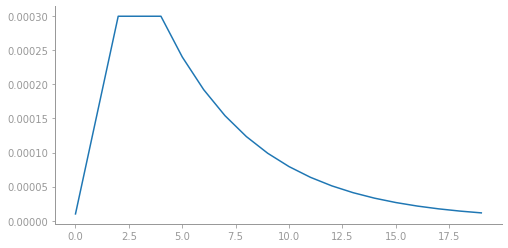

In [ ]:
lr_params =  [1e-5,  3e-4,  1e-6, 2, 2, 8e-1]

def lrfn(epoch, lr_params = lr_params):
    lr_start, lr_max, lr_min, lr_ramp_ep, lr_sus_ep, lr_decay = lr_params
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max 
    else:
        lr = (lr_max - lr_min)*lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr

def lr_schedule_builder(params):
    return tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lrfn(epoch, params), verbose=False) 

lr_sched = lr_schedule_builder(lr_params)

label_smoothing = 0.05
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing) 

plot_lr_timeline(lrfn, lr_params, num_epochs = EPOCHS)

### Summary and Log Function

In [ ]:
def sess_summary(model_dict, counts, dataset_deets = True): 
    DIM = model_dict['DIM']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)
    log_name = '{}_F{}_summary.txt'.format(model_dict['name'], model_dict['fold'])
    with open(log_name, 'w') as f:
        f.write('\nBase: {}'.format(base_name.title()))
        f.write('\nFold num: {}'.format(model_dict['fold']))
        f.write('\nWeights: {}\n'.format(model_dict['weights']))

        if dataset_deets:
            f.write('\nValidation shards: {}'.format(folds[model_dict['fold']]['val']))
            f.write('\nTotal training images: {}'.format(counts[0]))
            f.write('\nTotal val images: {}'.format(counts[1]))
            f.write('\nBatch size: {}'.format(BATCH_SIZE))
            f.write('\nMax number of epochs: {}'.format(EPOCHS))
            f.write('\nSteps per epoch: {}\n'.format(STEPS_PER_EPOCH))

        f.write('\nTPU implemented: {}'.format('Yes' if tpu != None else 'No'))
        f.write('\nNumber of replicas: {}'.format(strategy.num_replicas_in_sync))
        f.write('\nSize of input: {}'.format(INPUT_SHAPE))
        f.write('\nOptimizer: {}'.format(str(model_dict['opt']).split('.')[-2].title()))
        f.write('\nLR strategy: {}'.format(str(lr_sched).split('.')[2].split(' ')[0]))
        f.write('\nLR sched params: {}'.format(lr_params))
        f.write('\nLoss: {}'.format(str(loss).split('.')[2].split(' ')[0]))
        f.write('\nLabel smoothing: {}\n\n'.format(label_smoothing))
    !cat {log_name}

In [ ]:
def sess_summary_new(model_dict, counts, dataset_deets = True): 
    DIM = model_dict['DIM']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)
    log_name = '{}_F{}_summary.txt'.format(model_dict['name'], model_dict['fold'])
    with open(log_name, 'w') as f:
        f.write('\nBase: {}'.format(base_name.title()))
        f.write('\nWeights: {}\n'.format(model_dict['weights']))

        if dataset_deets:
            f.write('\nTotal training images: {}'.format(counts[0]))
            f.write('\nTotal val images: {}'.format(counts[1]))
            f.write('\nBatch size: {}'.format(BATCH_SIZE))
            f.write('\nMax number of epochs: {}'.format(EPOCHS))
            f.write('\nSteps per epoch: {}\n'.format(STEPS_PER_EPOCH))

        f.write('\nTPU implemented: {}'.format('Yes' if tpu != None else 'No'))
        f.write('\nNumber of replicas: {}'.format(strategy.num_replicas_in_sync))
        f.write('\nSize of input: {}'.format(INPUT_SHAPE))
        f.write('\nOptimizer: {}'.format(str(model_dict['opt']).split('.')[-2].title()))
        f.write('\nLR strategy: {}'.format(str(lr_sched).split('.')[2].split(' ')[0]))
        f.write('\nLR sched params: {}'.format(lr_params))
        f.write('\nLoss: {}'.format(str(loss).split('.')[2].split(' ')[0]))
        f.write('\nLabel smoothing: {}\n\n'.format(label_smoothing))
    !cat {log_name}

# **Training**

In [ ]:
#@title Training Dictionaries (Training Parameters)
#@markdown - EfficientNet B3
EB3_F0 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.5, 
            'name': 'EB3',
            'fold': 0}  

EB3_F1 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.5, 
            'name': 'EB3',
            'fold': 1}  

EB3_F2 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB3',
            'fold': 2}  

EB3_F3 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': 0.2, 
            'name': 'EB3',
            'fold': 3}

EB3_F4 = {'base_model': efn_dict[3]['model'], 
            'DIM': efn_dict[3]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB4',
            'fold': 4}

#@markdown - EfficientNet B4 
EB4_F0 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 0}

EB4_F1 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Radam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 1}

EB4_F2 = {'base_model': efn_dict[4]['model'],
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 2}

EB4_F3 = {'base_model': efn_dict[4]['model'], 
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB4',
            'fold': 3}  

EB4_F4 = {'base_model': efn_dict[4]['model'], 
            'DIM': efn_dict[4]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False, 
            'name': 'EB4',
            'fold': 4}

EB5_F1 = {'base_model': efn_dict[5]['model'], 
            'DIM': efn_dict[5]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.2, 
            'name': 'EB5',
            'fold': 1}
#@markdown - EfficientNet B6 
EB6_F0 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 0}

EB6_F1 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Radam'],
            'weights': 'imagenet',
            'head_dropout': 0.5,
            'name': 'EB6',
            'fold': 1}

EB6_F2 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 2}

EB6_F3 = {'base_model': efn_dict[6]['model'], 
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': 0.2,
            'name': 'EB6',
            'fold': 3}

EB6_F4 = {'base_model': efn_dict[6]['model'],
            'DIM': efn_dict[6]['size'],
            'opt': opts['Nadam'],
            'weights': 'noisy-student',
            'head_dropout': False,
            'name': 'EB6',
            'fold': 4}

In [ ]:
ensemble_components = [EB3_F1,EB4_F1]

In [ ]:
list_history = []

In [ ]:
dict_test_dataset = {}

In [ ]:
for component_dict in ensemble_components:
    model, base_name = ensemble_component(component_dict)
    train_dataset, valid_dataset, test_dataset, STEPS_PER_EPOCH, counts = build_datasets_new(component_dict)
    sess_summary_new(component_dict, counts, dataset_deets = True)

    weights_file = '{}_F{}_weights.h5'.format(component_dict['name'], component_dict['fold'])
    component_dict['weights_file'] = weights_file
    dict_test_dataset[component_dict['name']] = test_dataset
    checkpoint = config_checkpoint(weights_file)

    history = model.fit(train_dataset, epochs=EPOCHS, verbose=True, 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        callbacks=[checkpoint, lr_sched],
                        validation_data=valid_dataset)
    list_history.append({component_dict['name']:history})

============= Initial Malignant Data Counts ==============
 Training :  407
 Validation:  116
 Test :  58
 Augmented Malignant Training Count :  3256
 All Malignant Training Count :  3663
============= Initial Bening Data Counts ==============
 Training :  22478
 Validation:  6422
 Test :  3211
============= Selected Bening Data Counts ==============
 Training :  3663
 Validation:  232
 Test :  116
============= Final Built Data Counts ==============
 Training :  7326
 Validation:  348
 Test :  174


Dataset: shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)
Dataset: shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)
Dataset: shapes: ((300, 300, 3), (), ()), types: (tf.float32, tf.string, tf.int64)

Base: Efficientnet-B3
Weights: noisy-student

Total training images: 7326
Total val images: 348
Batch size: 160
Max number of epochs: 16
Steps per epoch: 46

TPU implemented: Yes
Number of replicas: 8
Size of input: (300, 300, 3)
Optimizer: Nadam
LR st

Instructions for updating:
use `experimental_local_results` instead.


46/46 [==============================] - 211s 1s/step - loss: 0.6868 - auc: 0.5658 - accuracy: 0.5516 - val_loss: 0.6935 - val_auc: 0.4846 - val_accuracy: 0.5057 - lr: 1.0000e-05
Epoch 2/16
46/46 [==============================] - 21s 459ms/step - loss: 0.4784 - auc: 0.8728 - accuracy: 0.7860 - val_loss: 0.6525 - val_auc: 0.7387 - val_accuracy: 0.6897 - lr: 1.5500e-04
Epoch 3/16
46/46 [==============================] - 21s 466ms/step - loss: 0.3127 - auc: 0.9628 - accuracy: 0.8995 - val_loss: 0.5963 - val_auc: 0.7994 - val_accuracy: 0.7241 - lr: 3.0000e-04
Epoch 4/16
46/46 [==============================] - 18s 397ms/step - loss: 0.2255 - auc: 0.9881 - accuracy: 0.9526 - val_loss: 0.7095 - val_auc: 0.7959 - val_accuracy: 0.7356 - lr: 3.0000e-04
Epoch 5/16
46/46 [==============================] - 22s 470ms/step - loss: 0.1844 - auc: 0.9960 - accuracy: 0.9743 - val_loss: 0.6440 - val_auc: 0.8184 - val_accuracy: 0.7615 - lr: 3.0000e-04
Epoch 6/16
46/46 [==============================] - 2

# Performance Anaysis

In [ ]:
#@markdown Rebuild Classifiers Functions (for Inference)
#@markdown - Build untrained classifier
def get_untrained_model(model_dict):
    # Get Specs
    base_model = model_dict['base_model']
    DIM = model_dict['DIM']
    opt = model_dict['opt']
    INPUT_SHAPE = (DIM, DIM, N_CHANNELS)

    # Build Model
    K.clear_session()
    with strategy.scope():
        base = base_model(weights=None, include_top=False, input_shape=INPUT_SHAPE)                                       
        model = build_model(base, N_CLASSES, INPUT_SHAPE) 
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC','accuracy']) 

    print('Built {} based model with random weights'.format(base.name.title()))
    return model
#@markdown - Load trained weights
def switch_weights(model, model_dict):
    weights_path = model_dict['weights_file']
    model.load_weights(weights_path)
    print('Assigned FOLD {} weights to {}-based model'.format(
        model_dict['fold'], model.name.split('_')[0]))
    return model

In [ ]:
#@markdown Prediction Function
def get_predictions_new(valid_dataset, valid_orig_imgs, NUM_VALIDATION_IMAGES):
    print('\nMaking Predictions:')
    eval = model.evaluate(valid_dataset, verbose=True, return_dict=False) # evaluation as in training
    pred_orig = model.predict(valid_orig_imgs, verbose=1) # these are the predictions on the un-augmented valid set
    return eval, pred_orig

In [ ]:
folds_idx = [1] # the index in models_folds of the fold to be used
efn_vers_idx = [0,1] # the index of the efn version to be used 0 for B3, 1 for B4, 2 for B6, 3 for B5

In [ ]:
#@markdown Folds Models Lists
models_fold_0 = [EB3_F0, EB4_F0, EB6_F0]
models_fold_1 = [EB3_F1, EB4_F1, EB6_F1, EB5_F1]
models_fold_2 = [EB3_F2, EB4_F2, EB6_F2]
models_fold_3 = [EB3_F3, EB4_F3, EB6_F3]
models_fold_4 = [EB3_F4, EB4_F4, EB6_F4]

models_folds = [models_fold_0, models_fold_1, models_fold_2, 
                models_fold_3, models_fold_4]

In [ ]:
#Plotting the model Accurcay and Loss
def print_loss_history(training_history,name):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    #plt.plot([0, 1], [0, 1])
    plt.title('Training and validation loss - '+name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def print_accuracy_history(training_history,name):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training accuracy')
    plt.plot(epochs, val_acc, color='green', label='Validation accuracy')
    #plt.plot([0, 1], [0, 1])
    plt.title('Training and validation accuracy - '+name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return

=================  EB3  ====================================


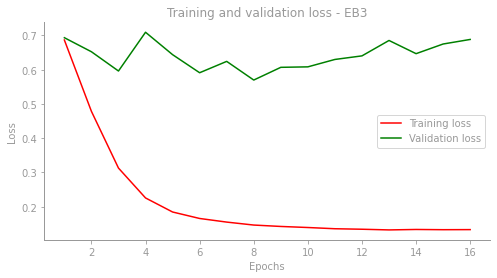

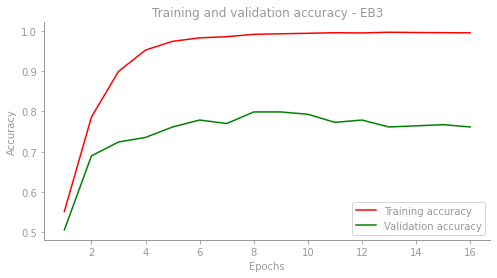

=================  EB4  ====================================


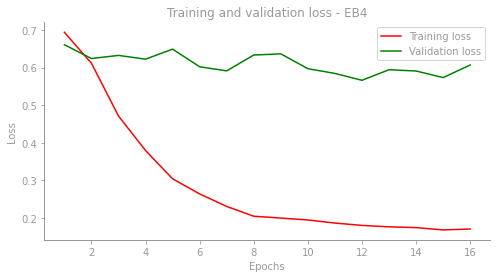

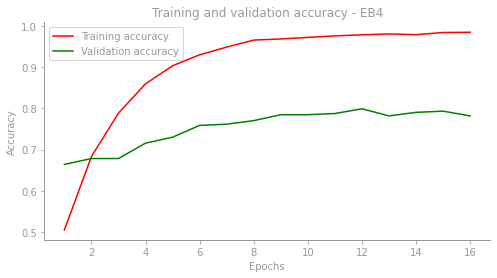

In [ ]:
for history in list_history:
  for key, value in history.items():
    print("================= ",key," ====================================")
    print_loss_history(value,key)
    print_accuracy_history(value,key)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

Processing models for FOLD 1 
Getting targets and names
Built Efficientnet-B3 based model with random weights
Assigned FOLD 1 weights to Efficientnet-B3-based model

Making Predictions:
2/2 [==============================] - 44s 7s/step

Evaluation Results:


,component,tf_eval,no_aug
0,EB3_F1,0.89291,0.893579




================  EB3  =================
classification_report -  EB3
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       116
           1       0.80      0.55      0.65        58

    accuracy                           0.80       174
   macro avg       0.80      0.74      0.76       174
weighted avg       0.80      0.80      0.79       174

Confusion matrix -  EB3


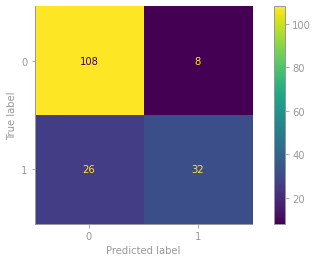

 ROC curve -  EB3
ROC -->  0.7413793103448275


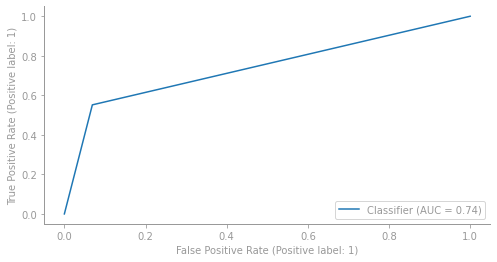

Built Efficientnet-B4 based model with random weights
Assigned FOLD 1 weights to Efficientnet-B4-based model

Making Predictions:
2/2 [==============================] - 54s 10s/step

Evaluation Results:


,component,tf_eval,no_aug
0,EB4_F1,0.88436,0.884215




================  EB4  =================
classification_report -  EB4
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       116
           1       0.84      0.53      0.65        58

    accuracy                           0.81       174
   macro avg       0.82      0.74      0.76       174
weighted avg       0.81      0.81      0.80       174

Confusion matrix -  EB4


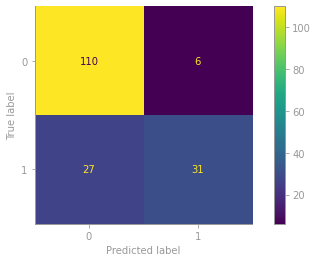

 ROC curve -  EB4
ROC -->  0.7413793103448275


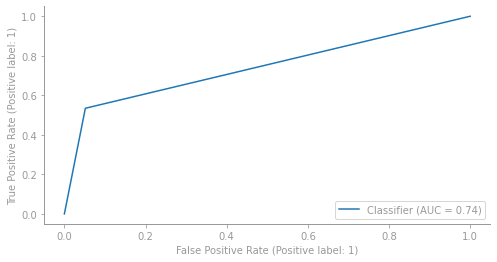

In [ ]:
#@markdown Prediction and Evaluation Loop Version 1.1
#TTA = 30 # Test time augmentation Steps 
#cols = ['component', 'tf_eval', 'no_aug', 'tta_10', 'tta_20', 'tta_30', 'best']
cols = ['component', 'tf_eval', 'no_aug']
list_pred_component = []
aucsDF = pd.DataFrame(columns = cols)

# for fold_num, models_fold in enumerate(models_folds): # START OUTER LOOP
for fold_num in folds_idx: # START OUTER LOOP
    print('Processing models for FOLD {} \nGetting targets and names'.format(fold_num))

    models_fold = models_folds[fold_num]

    # for model_index, model_dict in enumerate(models_fold): # START INNER LOOP
    for model_index in efn_vers_idx: # START INNER LOOP
        model_dict = models_fold[model_index]

        test_dataset = dict_test_dataset[model_dict['name']]
        # retrive the targets
        val_targets_ds = test_dataset.map(lambda image, image_name, target: target)
        val_targets = np.array([target.numpy() for target in iter(val_targets_ds)])
        
        # retrieve image names
        val_names_ds = test_dataset.map(lambda image, image_name, target: image_name)
        val_names = [image_name.numpy().decode("utf-8") for image_name in iter(val_names_ds)] 

        # Create one of this for each FOLD, put info of all 3 models here. 
        predsDF = pd.DataFrame({'image_name': val_names, 'target': val_targets})

        model = get_untrained_model(model_dict) 
        DIM = model_dict['DIM']
        model = switch_weights(model, model_dict)

        # valid_dataset, VALIDATION_FILENAMES_used, _ = unaugmented_val_dataset(model_dict['fold'], DIM)
        # assert VALIDATION_FILENAMES == VALIDATION_FILENAMES_used, 'VALIDATION_FILENAMES are not the same'

        valid_orig_imgs = test_dataset.map(lambda image, image_name, target: image)
        valid_orig_imgs = valid_orig_imgs.batch(BATCH_SIZE)
        #valid_aug_imgs  = tta_validation_datasets(VALIDATION_FILENAMES, DIM)[0]

        test_dataset_eval = test_dataset.map(lambda image, image_name, target: getTrainingElements(image, target))
        test_dataset_eval = test_dataset_eval.batch(BATCH_SIZE)
        
        eval, pred_orig= get_predictions_new(test_dataset_eval, valid_orig_imgs, counts[2])
        eval_auc = round(eval[1], 5)

        col_prefix = '{}_F{}'.format(model_dict['name'], model_dict['fold'])
        predsDF[col_prefix+'_NOAUG'] = pred_orig
        # predsDF[col_prefix+'_TTA10'] = np.mean(tta_preds[:,:10], axis = 1)
        # predsDF[col_prefix+'_TTA20'] = np.mean(tta_preds[:,:20], axis = 1)
        # predsDF[col_prefix+'_TTA30'] = np.mean(tta_preds, axis = 1)

        AUCs = {}
        AUCs['component'] = col_prefix
        AUCs['tf_eval'] = eval_auc
        AUCs['no_aug'] = roc_auc_score(val_targets, pred_orig)
        # AUCs['tta_10'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA10'])
        # AUCs['tta_20'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA20'])
        # AUCs['tta_30'] = roc_auc_score(val_targets, predsDF[col_prefix+'_TTA30'])

        aucsDF = aucsDF.append([AUCs])
        #aucsDF['best']=aucsDF[aucsDF.columns[-5:-1]].idxmax(axis=1) 
        print('\nEvaluation Results:')
        display(aucsDF[aucsDF.component == col_prefix])
        print('\n')
        pred_comp = {
            'baseModel':model_dict['name'],
            'validation_targets':val_targets,
            'validation_pred_orig':pred_orig
        }
        list_pred_component.append(pred_comp)
        pred_orig_rint = np.rint(pred_orig).astype(np.uint8).clip(0, 1)
        print("================ ",model_dict['name']," =================")
        print('classification_report - ',model_dict['name'])
        print(classification_report(val_targets, pred_orig_rint))
        print('Confusion matrix - ',model_dict['name'])
        # confusion_matrix_vals = confusion_matrix(validation_targets, validation_pred_orig)
        # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_vals)
        # disp.plot()
        ConfusionMatrixDisplay.from_predictions(val_targets, pred_orig_rint)
        plt.show()
        print(' ROC curve - ',model_dict['name'])
        print("ROC --> ",roc_auc_score(val_targets, pred_orig_rint))
        RocCurveDisplay.from_predictions(val_targets, pred_orig_rint)
        plt.show()

        # END inner loop

    # back to outer loop
    preds_file_name = 'preds_fold_{}.csv'.format(fold_num)
    predsDF.to_csv(preds_file_name, index=False)

# END of outer loop
aucsDF.to_csv('AUCS.csv', index=False)